In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import warnings 
warnings.filterwarnings("ignore")

### Project Overview
1. Determine what the top 5 diagnoses are
2. Explore demographic trends related to the top Medicare Diagnosis
3. Explore medicare spending related to the top Medicare diagnosis

### About the Medicare Carrier Claims File
Description: The CMS BSA Carrier Line Items PUF is a line item level file in which each record is a line item of a Carrier claim incurred by a 5% sample of Medicare beneficiaries. <br>
Filename: 2010_BSA_Carrier_PUF.csv <br>
File type: Comma Delimited <br>
Source: Center for Medicaid and Medicare Services <br>
Fields:

| Field | Description |
| --- | --- |
| BENE_SEX_IDENT_CD | Sex |
| BENE_AGE_CAT_CD | Gender |
| CAR_LINE_ICD9_DGNS_CD | ICD-9-CM Diagnosis Code|
| CAR_LINE_HCPCS_CD | HCPCS Procedure Code |
| CAR_LINE_BETOS_CD | Berenson-Eggers Type of Service (BETOS)|
| CAR_LINE_SRVC_CNT | Total # of services for the line item (procedure) |
| CAR_LINE_PRVDR_TYPE_CD | Type of Provider e.g. Clinic, groups, associations |
|CAR_HCPS_PMT_AMT |Payment made by Medicare |
|CAR_LINE_CNT | Number of carrier line items associated with each profile |

### References:
Source: www.cms.gov/data-research/statistics-trends-and-reports/basic-stand-alone-medicare-claims-public-use-files/bsa-dme-line-items-puf <br>
Official Data Definitions: https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2010_Carrier_Data_Dictionary.pdf<br>
CPT Codes: https://www.cms.gov/license/ama?file=/Medicare/Fraud-and-Abuse/PhysicianSelfReferral/Downloads/2012Addendum.zip <br>

In [33]:
df = pd.read_csv('2010_BSA_Carrier_PUF.csv')
df.head()

,BENE_SEX_IDENT_CD,BENE_AGE_CAT_CD,CAR_LINE_ICD9_DGNS_CD,CAR_LINE_HCPCS_CD,CAR_LINE_BETOS_CD,CAR_LINE_SRVC_CNT,CAR_LINE_PRVDR_TYPE_CD,CAR_LINE_CMS_TYPE_SRVC_CD,CAR_LINE_PLACE_OF_SRVC_CD,CAR_HCPS_PMT_AMT,CAR_LINE_CNT
0,1,1,NaN,99213,M1B,1,1,1,11,55,2
1,1,1,NaN,A0425,O1A,1,3,D,41,5,46
2,1,1,NaN,A0425,O1A,1,3,D,41,10,47
3,1,1,NaN,A0425,O1A,2,3,D,41,10,363
4,1,1,NaN,A0425,O1A,2,3,D,41,15,12


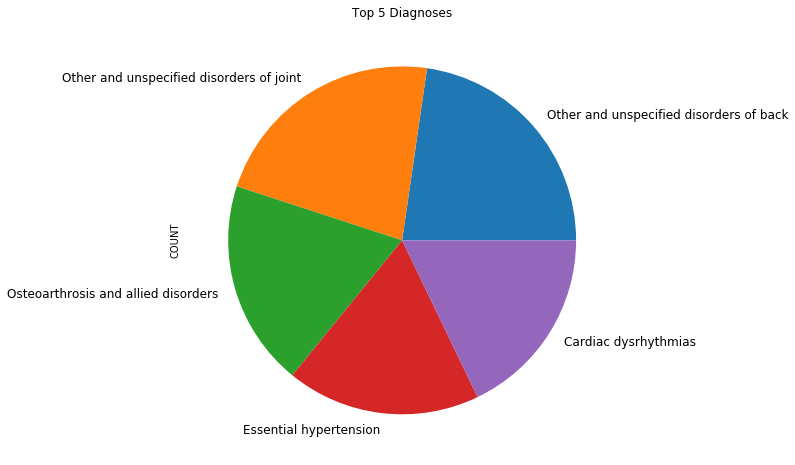

In [34]:
# Sort line items by the most common diagnosis
df['CAR_LINE_ICD9_DGNS_CD'].value_counts(ascending=False)

# Filter all line items for the top 5 diagnoses
top_5_filter = df['CAR_LINE_ICD9_DGNS_CD'].isin([724, 719, 715, 401, 427])
top_5_df = df[top_5_filter]
top_5_counts = top_5_df['CAR_LINE_ICD9_DGNS_CD'].value_counts().to_frame().reset_index()
top_5_counts.columns = ['DIAGNOSIS', 'COUNT']
top_5_counts = top_5_counts.set_index([pd.Index(['Other and unspecified disorders of back',
                                  'Other and unspecified disorders of joint',
                                  'Osteoarthrosis and allied disorders',
                                  'Essential hypertension',
                                  'Cardiac dysrhythmias'])])

#Display the top 5 most common diagnosis in a pie chart
top_5_counts.plot.pie(y='COUNT', title='Top 5 Diagnoses', figsize=(8,8), legend=False, fontsize=12)

In [35]:
# Map age category codes to their description
age_category_map = pd.DataFrame(data={'AGE_CAT': [1,2,3,4,5,6], 'AGE_CAT_DESC': ['Under 65', '65-69', '70-74', '75-79', '80-84', '85 and older']})
age_category_map.set_index('AGE_CAT', inplace=True)

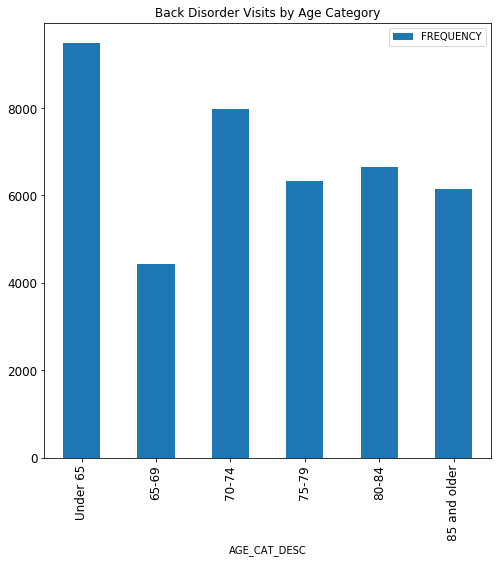

In [36]:
# Filter by diagnosis of back disorder and display a bar chart with age breakdown
back_disorders_filter = df['CAR_LINE_ICD9_DGNS_CD'].isin([724])
back_disorders_df = df[back_disorders_filter]
age_back_disorder_plot = pd.DataFrame(back_disorders_df['BENE_AGE_CAT_CD'].value_counts())
age_back_disorder_plot.index.name = 'BENE_AGE_CAT_CD'
age_back_disorder_plot.columns = ['FREQUENCY']
age_dist_back_disorders = age_back_disorder_plot.join(age_category_map).sort_values('BENE_AGE_CAT_CD')
age_dist_back_disorders.plot(kind='bar', x='AGE_CAT_DESC', title='Back Disorder Visits by Age Category', figsize=(8,8), fontsize=12)

**Analysis** <br>
Medicare patients "Under 65" received more medical care for back disorders than any of the other age category. Patients in the "Under 65" category were also twice as likely to receive care for back disorders than patients in the next age category up, "65-69". This finding is somewhat surprising as we'd back disorders to worsen as patients age. Perhaps as patients retire there are less physical demands on them and therefore they are less likely to seek medical care as the severity of their issues decreases.

### Examine Central Tendency of Medicare Payments for Carrier Line Items

In [37]:
# Use the interquartile range to identify the the middle 50% of the data
Q1 = np.percentile(back_disorders_df['CAR_HCPS_PMT_AMT'], 25)
Q3 = np.percentile(back_disorders_df['CAR_HCPS_PMT_AMT'], 75)
Q4 = np.percentile(back_disorders_df['CAR_HCPS_PMT_AMT'], 100)
IQR = Q3 - Q1
print("The 25th percentile of Medicare payments started at: " + str(Q1))
print("The 75th percentile of Medicare payments started at: " + str(Q3))
print("The interquartile range was: " + str(IQR))

The 25th percentile of Medicare payments started at: 15.0
The 75th percentile of Medicare payments started at: 95.0
The interquartile range was: 80.0


### Visualize the central tendency of the data using a kernel density plot
A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.

Text(0.75, 1, 'Distribution of Medicare Payment Amounts for Back Disorder Line Items')

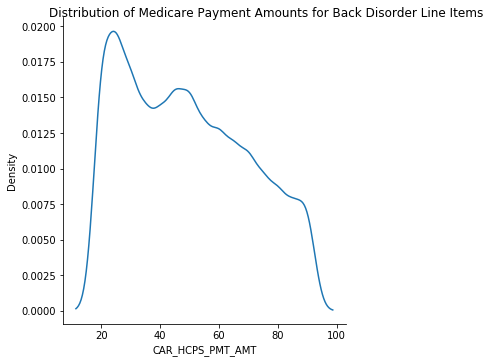

In [38]:
# Visualize how data is distributed in the middle 50% using kernel density to smooth the data
middle_distribution = back_disorders_df.loc[(back_disorders_df['CAR_HCPS_PMT_AMT'] > Q1) & (back_disorders_df['CAR_HCPS_PMT_AMT'] < Q3)]
ax = sns.displot(middle_distribution, x="CAR_HCPS_PMT_AMT", kind="kde")
ax.fig.suptitle("Distribution of Medicare Payment Amounts for Back Disorder Line Items", x=.75, y=1,
                  fontsize=12, fontdict={"weight": "bold"})

**Analysis** <br>
The plot above is positively skewed indicating that Medicare usually pays closer to \\$14 than \\$95 for procedures related to back disorders.

In [39]:
# Calculate the z-score of Medicare payment amounts for procedure codes related to back disorders
z = np.abs(stats.zscore(back_disorders_df['CAR_HCPS_PMT_AMT']))
back_disorders_df['zscore'] = z
back_disorder_outlier_df = back_disorders_df.loc[(back_disorders_df['zscore'] > 2)]
back_disorder_outlier_df['CAR_LINE_HCPCS_CD'].value_counts().head(5)

63047    87
63030    74
00670    66
22612    58
63042    54
Name: CAR_LINE_HCPCS_CD, dtype: int64

**Analysis** <br>
The top 5 most common procedures that were at least 2 standard deviations from the middle were: <br>
* Under Posterior Extradural Laminotomy or Laminectomy for Stenosis
* Under Posterior Extradural Laminotomy or Laminectomy for Herniated Disc
* Under Anesthesia for Procedures on the Spine and Spinal Cord
* Under Posterior, Posterolateral or Lateral Transverse Process Technique Arthrodesis...
* Under Posterior Extradural Laminotomy or Laminectomy for Exploration/ Decompression...


In [40]:
# Map the top 5 procedures to their descriptions
back_disorder_outlier_df = back_disorders_df.loc[(back_disorders_df['zscore'] > 2)]
back_disorder_outlier_df['CAR_LINE_HCPCS_CD'].value_counts()
procedure_map = pd.DataFrame(data={'CAR_LINE_HCPCS_CD':['63047', '63030', '00670', '22612', '63042'], 
                 'Procedure Description': ['Under Posterior Extradural Laminotomy or Laminectomy for Stenosis',
                 'Under Posterior Extradural Laminotomy or Laminectomy for Herniated Disc',
                 'Under Anesthesia for Procedures on the Spine and Spinal Cord',
                 'Under Posterior, Posterolateral or Lateral Transverse Process Technique Arthrodesis...',
                 'Under Posterior Extradural Laminotomy or Laminectomy for Exploration/ Decompression...']}
                )
procedure_map.set_index('CAR_LINE_HCPCS_CD', inplace=True)
back_disorder_outlier_df = back_disorder_outlier_df.join(procedure_map, on='CAR_LINE_HCPCS_CD')

In [41]:
back_disorder_outlier_df.dropna(subset = ['Procedure Description'], inplace=True)
back_disorder_outlier_df[['Procedure Description', 'CAR_HCPS_PMT_AMT']].groupby(['Procedure Description']).mean().rename(columns={'Procedure Description': 'Procedure Description', 'CAR_HCPS_PMT_AMT': 'Mean Medicare Spending Amount'})

,Mean Medicare Spending Amount
Procedure Description,
Under Anesthesia for Procedures on the Spine and Spinal Cord,719.696970
Under Posterior Extradural Laminotomy or Laminectomy for Exploration/ Decompression...,1050.000000
Under Posterior Extradural Laminotomy or Laminectomy for Herniated Disc,800.000000
Under Posterior Extradural Laminotomy or Laminectomy for Stenosis,817.241379
"Under Posterior, Posterolateral or Lateral Transverse Process Technique Arthrodesis...",951.724138


Analysis: 

In [42]:
back_disorder_outlier_df[['Procedure Description', 'CAR_HCPS_PMT_AMT']].groupby(['Procedure Description']).median().rename(columns={'Procedure Description': 'SERVICE', 'CAR_HCPS_PMT_AMT': 'Median Medicare Spending Amount'})

,Median Medicare Spending Amount
Procedure Description,
Under Anesthesia for Procedures on the Spine and Spinal Cord,700
Under Posterior Extradural Laminotomy or Laminectomy for Exploration/ Decompression...,900
Under Posterior Extradural Laminotomy or Laminectomy for Herniated Disc,800
Under Posterior Extradural Laminotomy or Laminectomy for Stenosis,800
"Under Posterior, Posterolateral or Lateral Transverse Process Technique Arthrodesis...",950


**Analysis**<br>
* A person receiving the procedure "Under Posterior, Posterolateral or Lateral Transverse Process Technique Arthrodesis...	"required the highest payment for their procedure at a median value of \\$950. <br>
* Anesthesia was less expensive than the other procedures but was probably a component of the patient's overall bill.